Praktikum

In [2]:
from google.colab import drive
drive.mount('/content/gdive')

Drive already mounted at /content/gdive; to attempt to forcibly remount, call drive.mount("/content/gdive", force_remount=True).


In [3]:
path = '/content/gdive/MyDrive/Machine Learning Sem3/Praktikum4'

In [4]:
import pandas as pd
df = pd.read_csv(path + '/Data/stunting_wasting_dataset.csv')
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
     accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
     confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay

)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [7]:
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [8]:
df.duplicated().sum()

np.int64(7308)

In [9]:
df = df.drop_duplicates()

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [12]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [13]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg)
Umur (bulan),1.000000,0.874162,0.659566
Tinggi Badan (cm),0.874162,1.000000,0.618453
Berat Badan (kg),0.659566,0.618453,1.000000


In [14]:
#1. Mapping kolom Stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

#2. Mapping holom Jenis Kelamin -> biner
# Laki-Laki = 1, Perempuan 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df[ 'Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    72320
1    20372
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    46353
0    46339
Name: count, dtype: int64


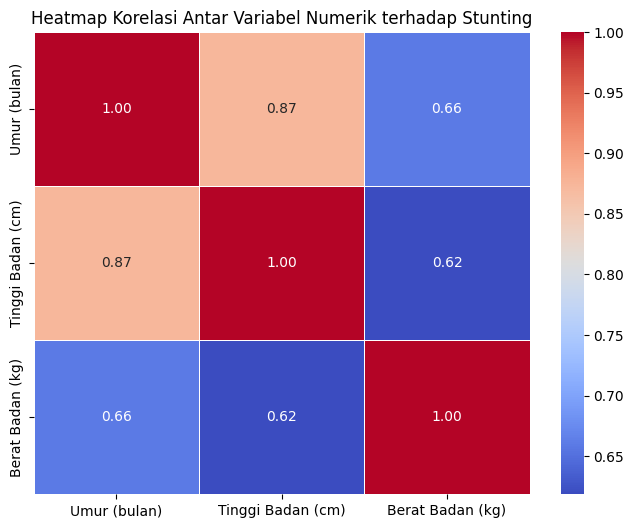

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik terhadap Stunting", fontsize=12)
plt.show()

In [16]:
# Fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df [use_cols].dropna().copy()

X = df_model [feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (92692, 4)
y shape: (92692,)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (74153, 4)
Data uji: (18539, 4)


In [18]:
#Scale hanya Fitur numerik, gender Langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_num),
         ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver= 'lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
     ('model', model)
])

#Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")

✅ Model Logistic Regression berhasil dilatih.


In [19]:
# Prediksi & probabilities
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitting metric
print(f"Akurasi : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi : 0.9063
Precision : 0.7139
Recall : 0.9571
F1-Score : 0.8178
ROC-AUC : 0.9651


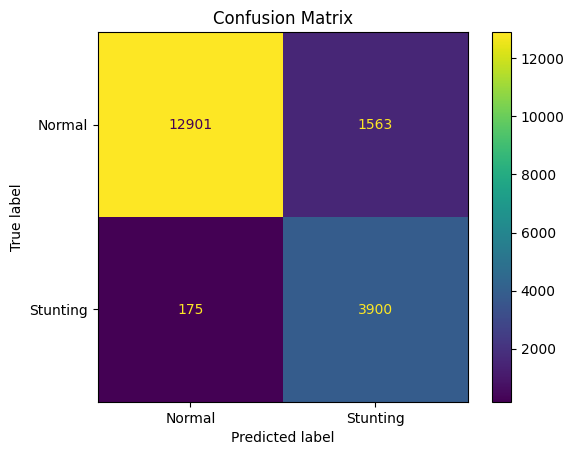

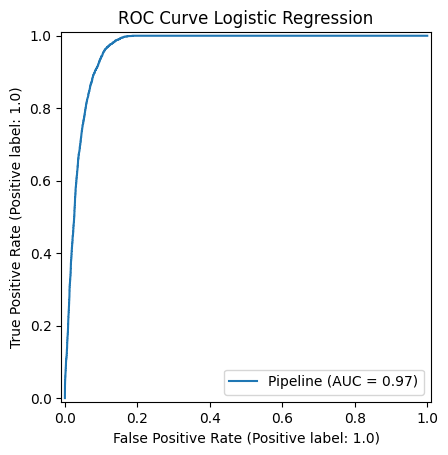

In [20]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
    display_labels=['Normal', 'Stunting']
    ).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.99      0.89      0.94     14464
      Stunting (1)       0.71      0.96      0.82      4075

          accuracy                           0.91     18539
         macro avg       0.85      0.92      0.88     18539
      weighted avg       0.93      0.91      0.91     18539



In [22]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standard deviasi:", np.std(scores))

Skor tiap fold: [0.9084093  0.90414801 0.90468227 0.90673212 0.9028482 ]
Rata-rata akurasi: 0.9053639814725255
Standard deviasi: 0.001970695381359219


In [23]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standard deviasi:", np.std(scores))

Skor tiap fold: [0.9084093  0.90414801 0.90468227 0.90673212 0.9028482 ]
Rata-rata akurasi: 0.9053639814725255
Standard deviasi: 0.001970695381359219


In [24]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'fitur': feat_names,
    'koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,fitur,koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.661420,5775.733054
3,JK_bin,1.726339,5.620042
2,Berat Badan (kg),0.653153,1.921590
1,Tinggi Badan (cm),-10.742834,0.000022


In [25]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0] # 1=Laki-Laki, 0=Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.998346,1.0
1,10,72.5,7.8,0,0.001810,0.0


Tugas 4

In [26]:
import pandas as pd

df = pd.read_csv("/content/gdive/MyDrive/Machine Learning Sem3/Praktikum4/Data/calonpembelimobil.csv")
df.head()

,ID,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Beli_Mobil
0,1,32,1,0,0,240,1
1,2,49,2,1,1,100,0
2,3,52,1,0,2,250,1
3,4,26,2,1,1,130,0
4,5,45,3,0,2,237,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ID              1000 non-null   int64
 1   Usia            1000 non-null   int64
 2   Status          1000 non-null   int64
 3   Kelamin         1000 non-null   int64
 4   Memiliki_Mobil  1000 non-null   int64
 5   Penghasilan     1000 non-null   int64
 6   Beli_Mobil      1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB


In [28]:
df.isnull().sum()

,0
ID,0
Usia,0
Status,0
Kelamin,0
Memiliki_Mobil,0
Penghasilan,0
Beli_Mobil,0


In [36]:
#fitur (X) dan target (y)
X = df[['Usia', 'Status', 'Kelamin', 'Memiliki_Mobil', 'Penghasilan']]
y = df['Beli_Mobil']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000, 5)
y shape: (1000,)


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (800, 5)
Data uji: (200, 5)


In [39]:
# Pipeline untuk training model
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced',
        random_state=42
    ))
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")

✅ Model Logistic Regression berhasil dilatih.


In [40]:
# Prediksi & probabilities
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitting metric
print(f"Akurasi : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi : 0.9300
Precision : 0.9829
Recall : 0.9055
F1-Score : 0.9426
ROC-AUC : 0.9768


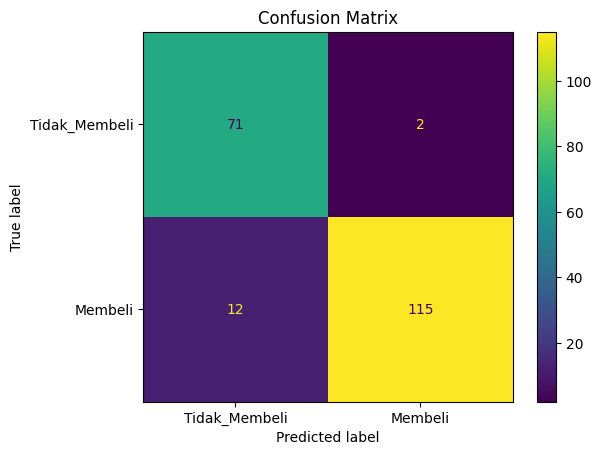

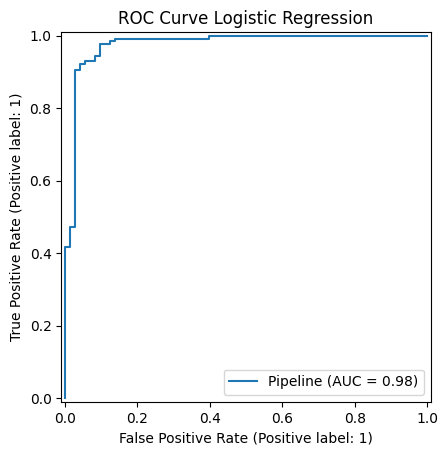

In [41]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
    display_labels=['Tidak_Membeli', 'Membeli']
    ).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Membeli (0)', 'Membeli (1)']))

                   precision    recall  f1-score   support

Tidak Membeli (0)       0.86      0.97      0.91        73
      Membeli (1)       0.98      0.91      0.94       127

         accuracy                           0.93       200
        macro avg       0.92      0.94      0.93       200
     weighted avg       0.94      0.93      0.93       200



In [43]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standard deviasi:", np.std(scores))

Skor tiap fold: [0.78  0.925 0.955 0.945 0.94 ]
Rata-rata akurasi: 0.909
Standard deviasi: 0.06522269543648128


In [45]:
# Ambil nama fitur & koefisien
feat_names = ['Usia', 'Penghasilan', 'Status', 'Kelamin', 'Memiliki_Mobil']
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'fitur': feat_names,
    'koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,fitur,koefisien (log-odds),Odds Ratio (e^coef)
4,Memiliki_Mobil,4.568333,96.383273
3,Kelamin,0.078968,1.082169
0,Usia,-0.045073,0.955928
1,Penghasilan,-0.132093,0.876259
2,Status,-0.596863,0.550536


In [47]:
# Contoh 2 calon pembeli
data_baru = pd.DataFrame({
    'Usia': [35, 50],
    'Status': [1, 2],  # 1=Menikah, 2=Cerai, 3=Lajang, 0=Lainnya
    'Kelamin': [0, 1], # 0=Perempuan, 1=Laki-Laki
    'Memiliki_Mobil': [1, 2], # 0=Tidak Punya, 1=Punya 1, 2=Punya 2+
    'Penghasilan': [300, 150] # dalam jutaan
})


pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Beli_Mobil'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Prob_Beli_Mobil,"Pred (0=Tidak,1=Ya)"
0,35,1,0,1,300,0.981852,1
1,50,2,1,2,150,0.010778,0
